In [94]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import scipy.optimize as opt
from collections import deque
import random

In [95]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams["figure.figsize"] = (20, 10)
style.use('ggplot')

In [96]:
t = np.linspace(-1, 3, 1000)
X, Y = np.meshgrid(t, t)

DELTA = 1e-3


def get_step(l):
    if l <= 50: return 1
    if l <= 100: return 2
    if l <= 250: return 5
    if l <= 500: return 10
    return 20


def draw_level_lines(f, plot, points, title):
    N = len(points)
    step = get_step(N)
    sample = np.array([points[i] for i in range(0, N, step)])
    plot.plot(sample[:, 0], sample[:, 1], 'o-')
    plot.contour(X, Y, f([X, Y]), levels=sorted([f(s) for s in sample]))
    plot.title(f"{title}\nIterations: {len(points)}.\nResult: {points[-1]}", color='black')


def draw_fun(f):
    ax = plt.figure().add_subplot(projection='3d')
    ax.plot_surface(X, Y, f([X, Y]))
    plt.show()

In [97]:
def num_diff(f, point, diff_coordinate, delta=1e-3):
    plus_delta = point.copy()
    plus_delta[diff_coordinate] += delta
    minus_delta = point.copy()
    minus_delta[diff_coordinate] -= delta
    return (f(plus_delta) - f(minus_delta)) / (2 * delta)


def gradient(f):
    return lambda point:np.array([num_diff(f, point, i) for i in range(len(point))])


## Стандартный GD

In [98]:
def stop(x, delta):
    return np.linalg.norm(x, 2) < delta


def gd(f, start, lr, max_epoch, delta=DELTA):
    points = np.zeros((max_epoch, len(start)))
    points[0] = start
    point = start.copy()
    grad = gradient(f)

    i = 1
    while i < max_epoch:
        gr = grad(point)
        point = point - lr * gr
        points[i] = point
        i += 1
        if stop(gr, delta):
            break

    return points[:i]


## Adam

In [99]:
def adam(f, start, lr, max_epoch, delta=DELTA, gamma_1=0.9, gamma_2=0.999, eps=1e-8):
    points = np.zeros((max_epoch, len(start)))
    v_prev = np.array([0, 0])
    s_prev = np.array([0, 0])
    points[0] = start
    point = start.copy()
    grad = gradient(f)

    i = 1
    while i < max_epoch:
        g = grad(point)
        v_current = gamma_1 * v_prev + (1 - gamma_1) * g
        s_current = gamma_2 * s_prev + (1 - gamma_2) * np.power(g, 2)
        v_normalize = v_current / (1 - np.power(gamma_1, i))
        s_normalize = s_current / (1 - np.power(gamma_2, i))
        point = point - lr * v_normalize / np.power(s_normalize + eps, 0.5)
        v_prev = v_current
        s_prev = s_current
        points[i] = point

        if stop(points[i] - points[i - 1], delta):
            i += 1
            break
        i += 1

    return points[:i]

## BFGS

### Определение

Метод BFGS относится к классу так называемых квазиньютоновских методов. В отличие от ньютоновских методов в квазиньютоновских не вычисляется напрямую гессиан функции, т.е. нет необходимости находить частные производные второго порядка. Вместо этого гессиан вычисляется приближенно, исходя из сделанных до этого шагов, что значительно удешевит итерацию.

### Алгоритм

1. Зададим начальные значения:
    * Начальная точка $x_0$
    * $H_0 = {B_0}^{-1}$, где ${B_0}^{-1}$ - обратный гессиан функции. За $H_0$ можно взять гессиан функции, вычисленный в начальной точке $x_0$ или единичную матрицу.

2. Находим точку, в направлении которой будем производить поиск: $$p_k = H_k \nabla f_k$$

3. Находим ${\alpha}_k$ через линейный поиск, удовлетворяющий условиям Вольфе:
$$f(x_k + \alpha_k p_k) \leq f(x_k) + c_1 \alpha_k \nabla {f_k}^T p_k$$
$$\nabla f(x_k + \alpha_k p_k)^T p_k \geq c_2 \nabla {f_k}^T p_k$$

4. Вычисляем $x_{k+1} = x_k + α_k * p_k$

5. Определим:
    * Шаг алгоритма итерации: $s_k = x_{k+1} - x_k$
    * Изменение градиента на итерации: $y_k = \nabla f_{k+1} - \nabla f_k$

6. Обновляем гессиан:
$$\rho_k = \frac {1} {y_k^T s_k}$$
$$H_{k+1} = (I - \rho_k  s_k  y_k^T) H_k (I - \rho_k  y_k  s_k^T) + \rho_k  s_k  s_k^T$$

7. Повторяем шаги *2-6*, пока  $|\nabla f_k| > \delta$.

### Ожидаемые преимущества метода

* Дешевые вычисления на итерации $O(n^2)$.
* Нет необходимости вычислять вторые производные.
* Самокорректирующееся свойство метода. Если оценка кривизны функции с ошибкой, тогда апроксимация гессиана стремится исправить ситуацию за несколько шагов.

### Недостатки

* Хранение $O(n^2)$ памяти на каждой итерации для больших $n$.


In [100]:
def bfgs(f, start, max_epoch, delta=DELTA):
    N = len(start)
    I = np.identity(N)
    grad_f = gradient(f)

    points = np.zeros((max_epoch, N))
    points[0] = start

    H = I
    gr = grad_f(start)
    point = start.copy()

    i = 1
    while i < max_epoch:
        p = -np.dot(H, gr)
        alpha = opt.line_search(f, grad_f, point, p, amax=100)[0]

        points[i] = point + alpha * p
        s = points[i] - point
        point = points[i]

        gr_point = grad_f(point)
        y = gr_point - gr
        gr = gr_point

        i += 1
        if stop(gr, delta):
            break

        rho = 1.0 / (np.dot(y, s))
        H = np.dot(I - rho * s[:, np.newaxis] * y[np.newaxis, :], H)
        H = np.dot(H, I - rho * y[:, np.newaxis] * s[np.newaxis, :])
        H = H + rho * s[:, np.newaxis] * s[np.newaxis, :]

    return points[:i]


## Сравним нахождение минимума функции обычного градиентного спуска (GD) и BFGS

Выберем функцию: $$f(x,y) = sin(y + 3.5) + (y - 1)^2$$

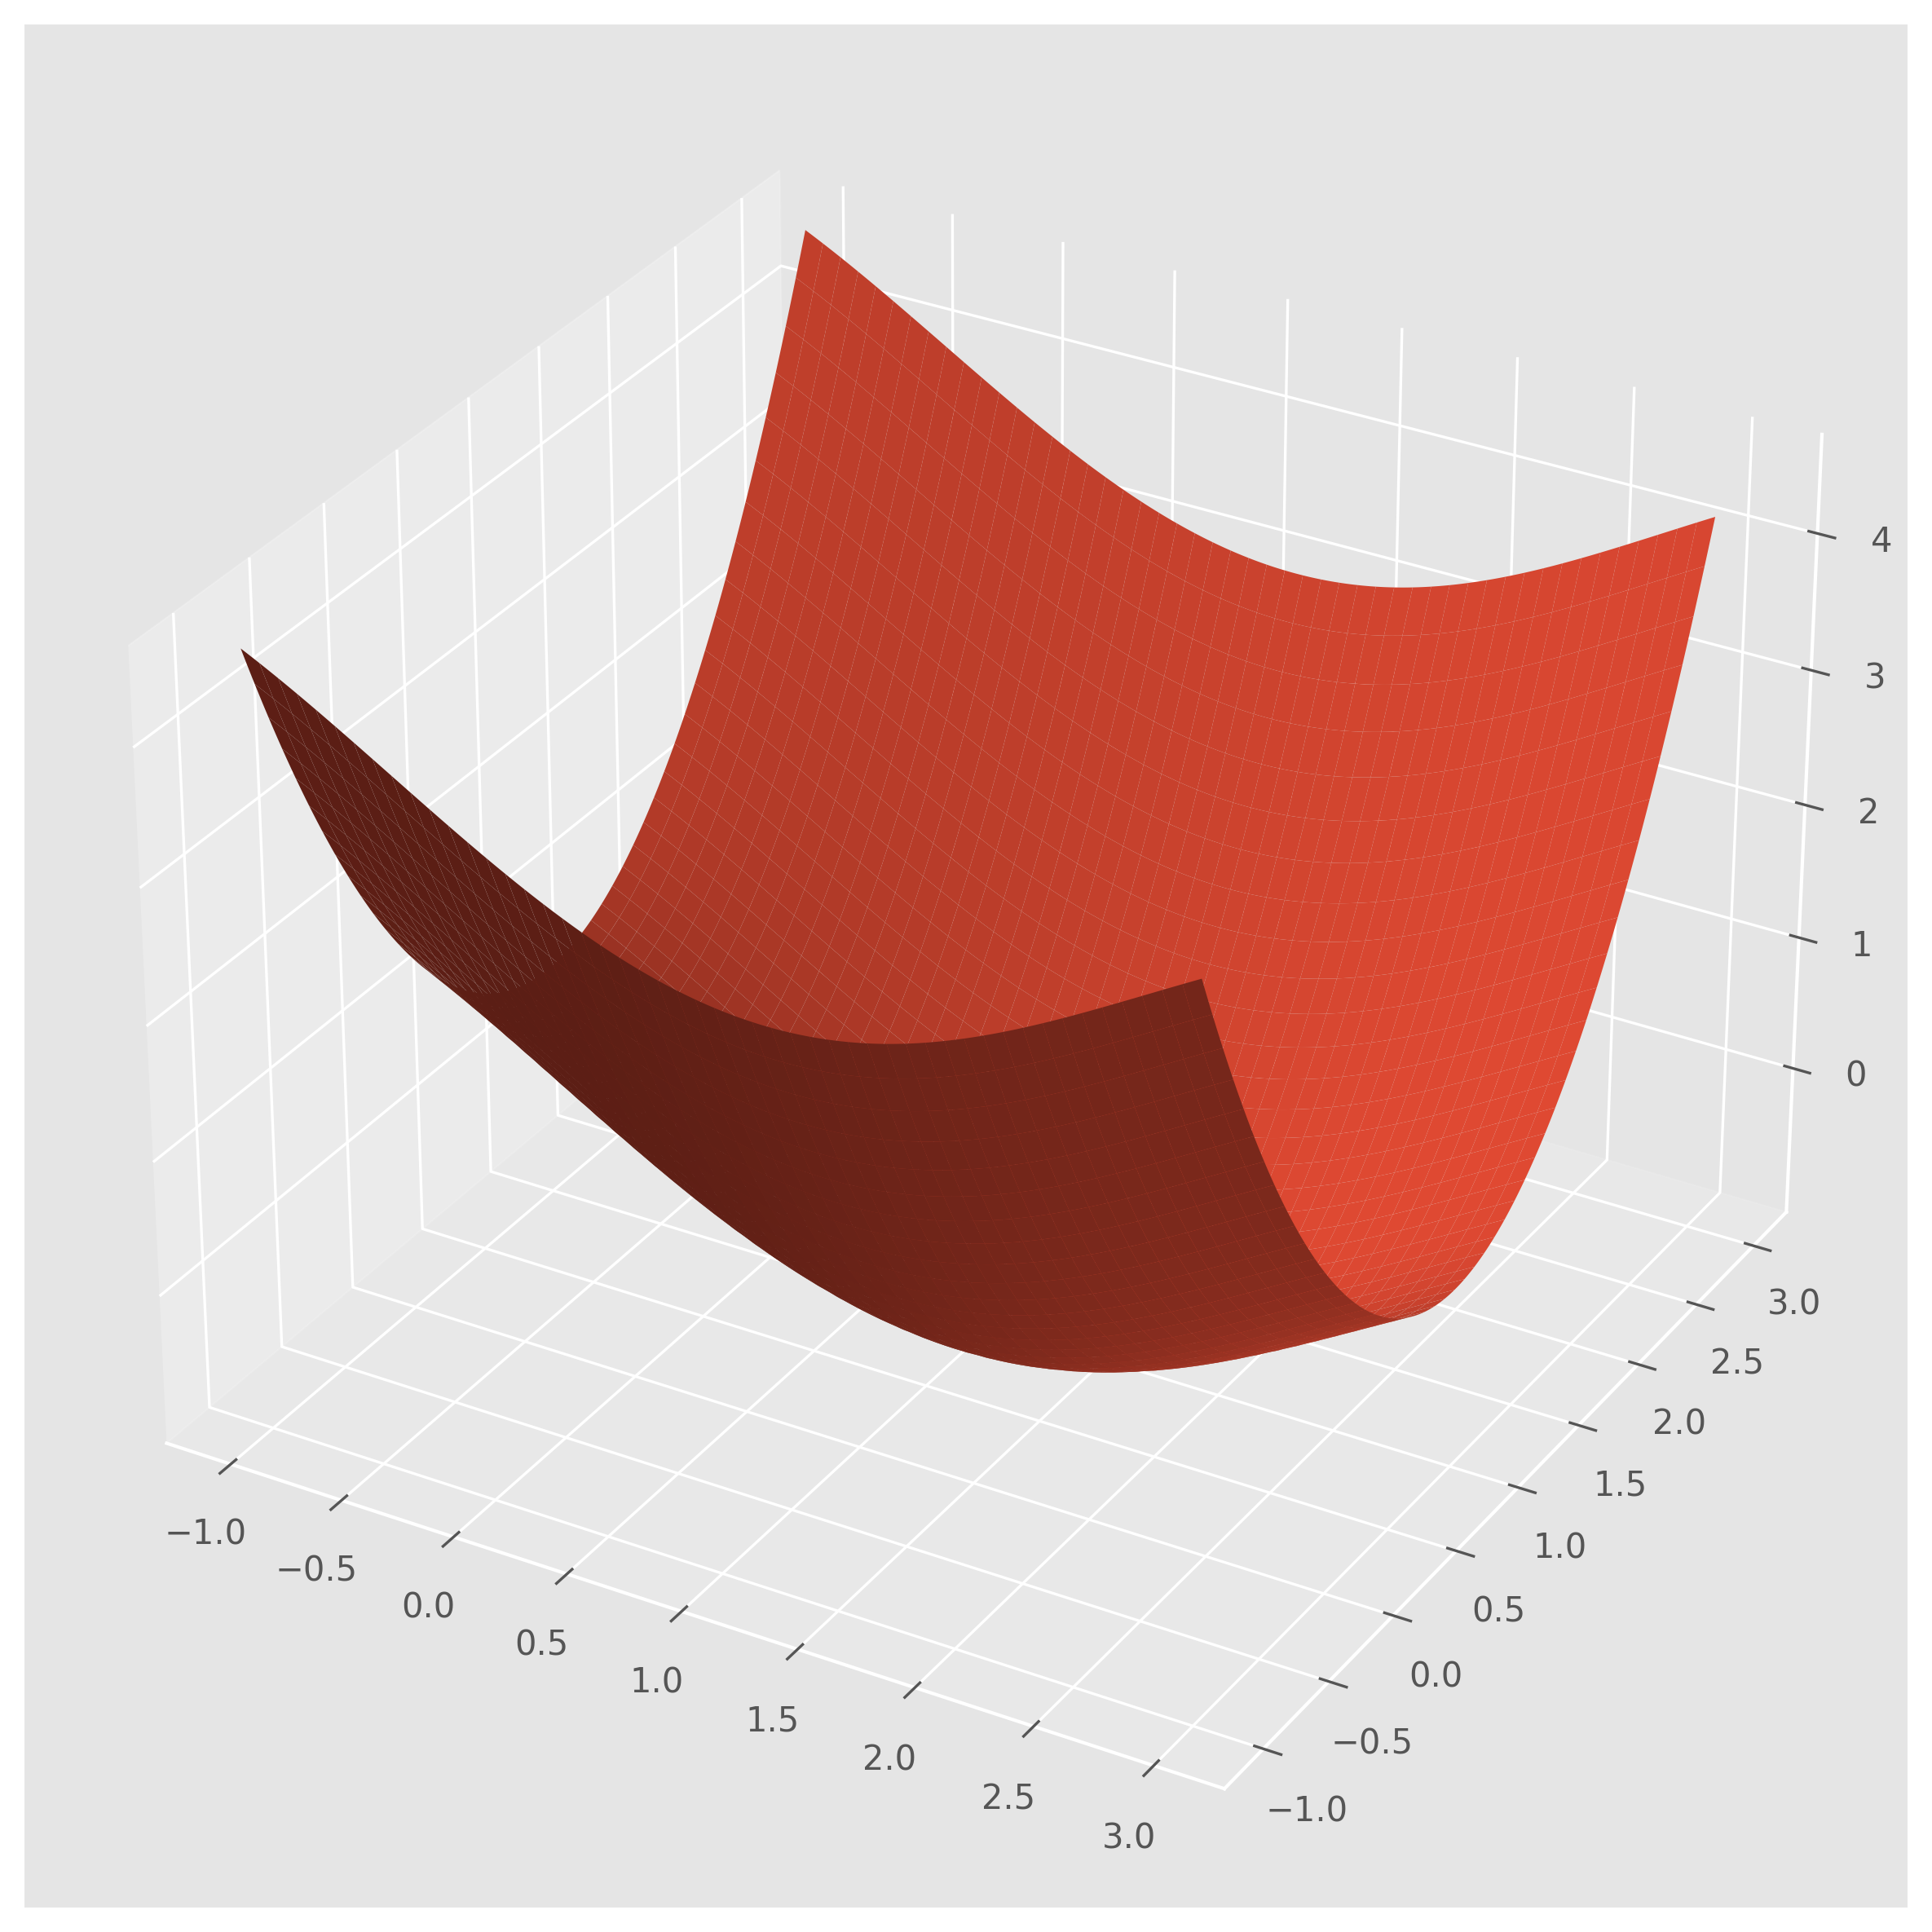

In [101]:
def fun(point):
    return np.sin(point[0] + 3.5) + (point[1] - 1) ** 2

draw_fun(fun)

In [102]:
start_point = np.array([0.5, 0.5])
epoch = 100

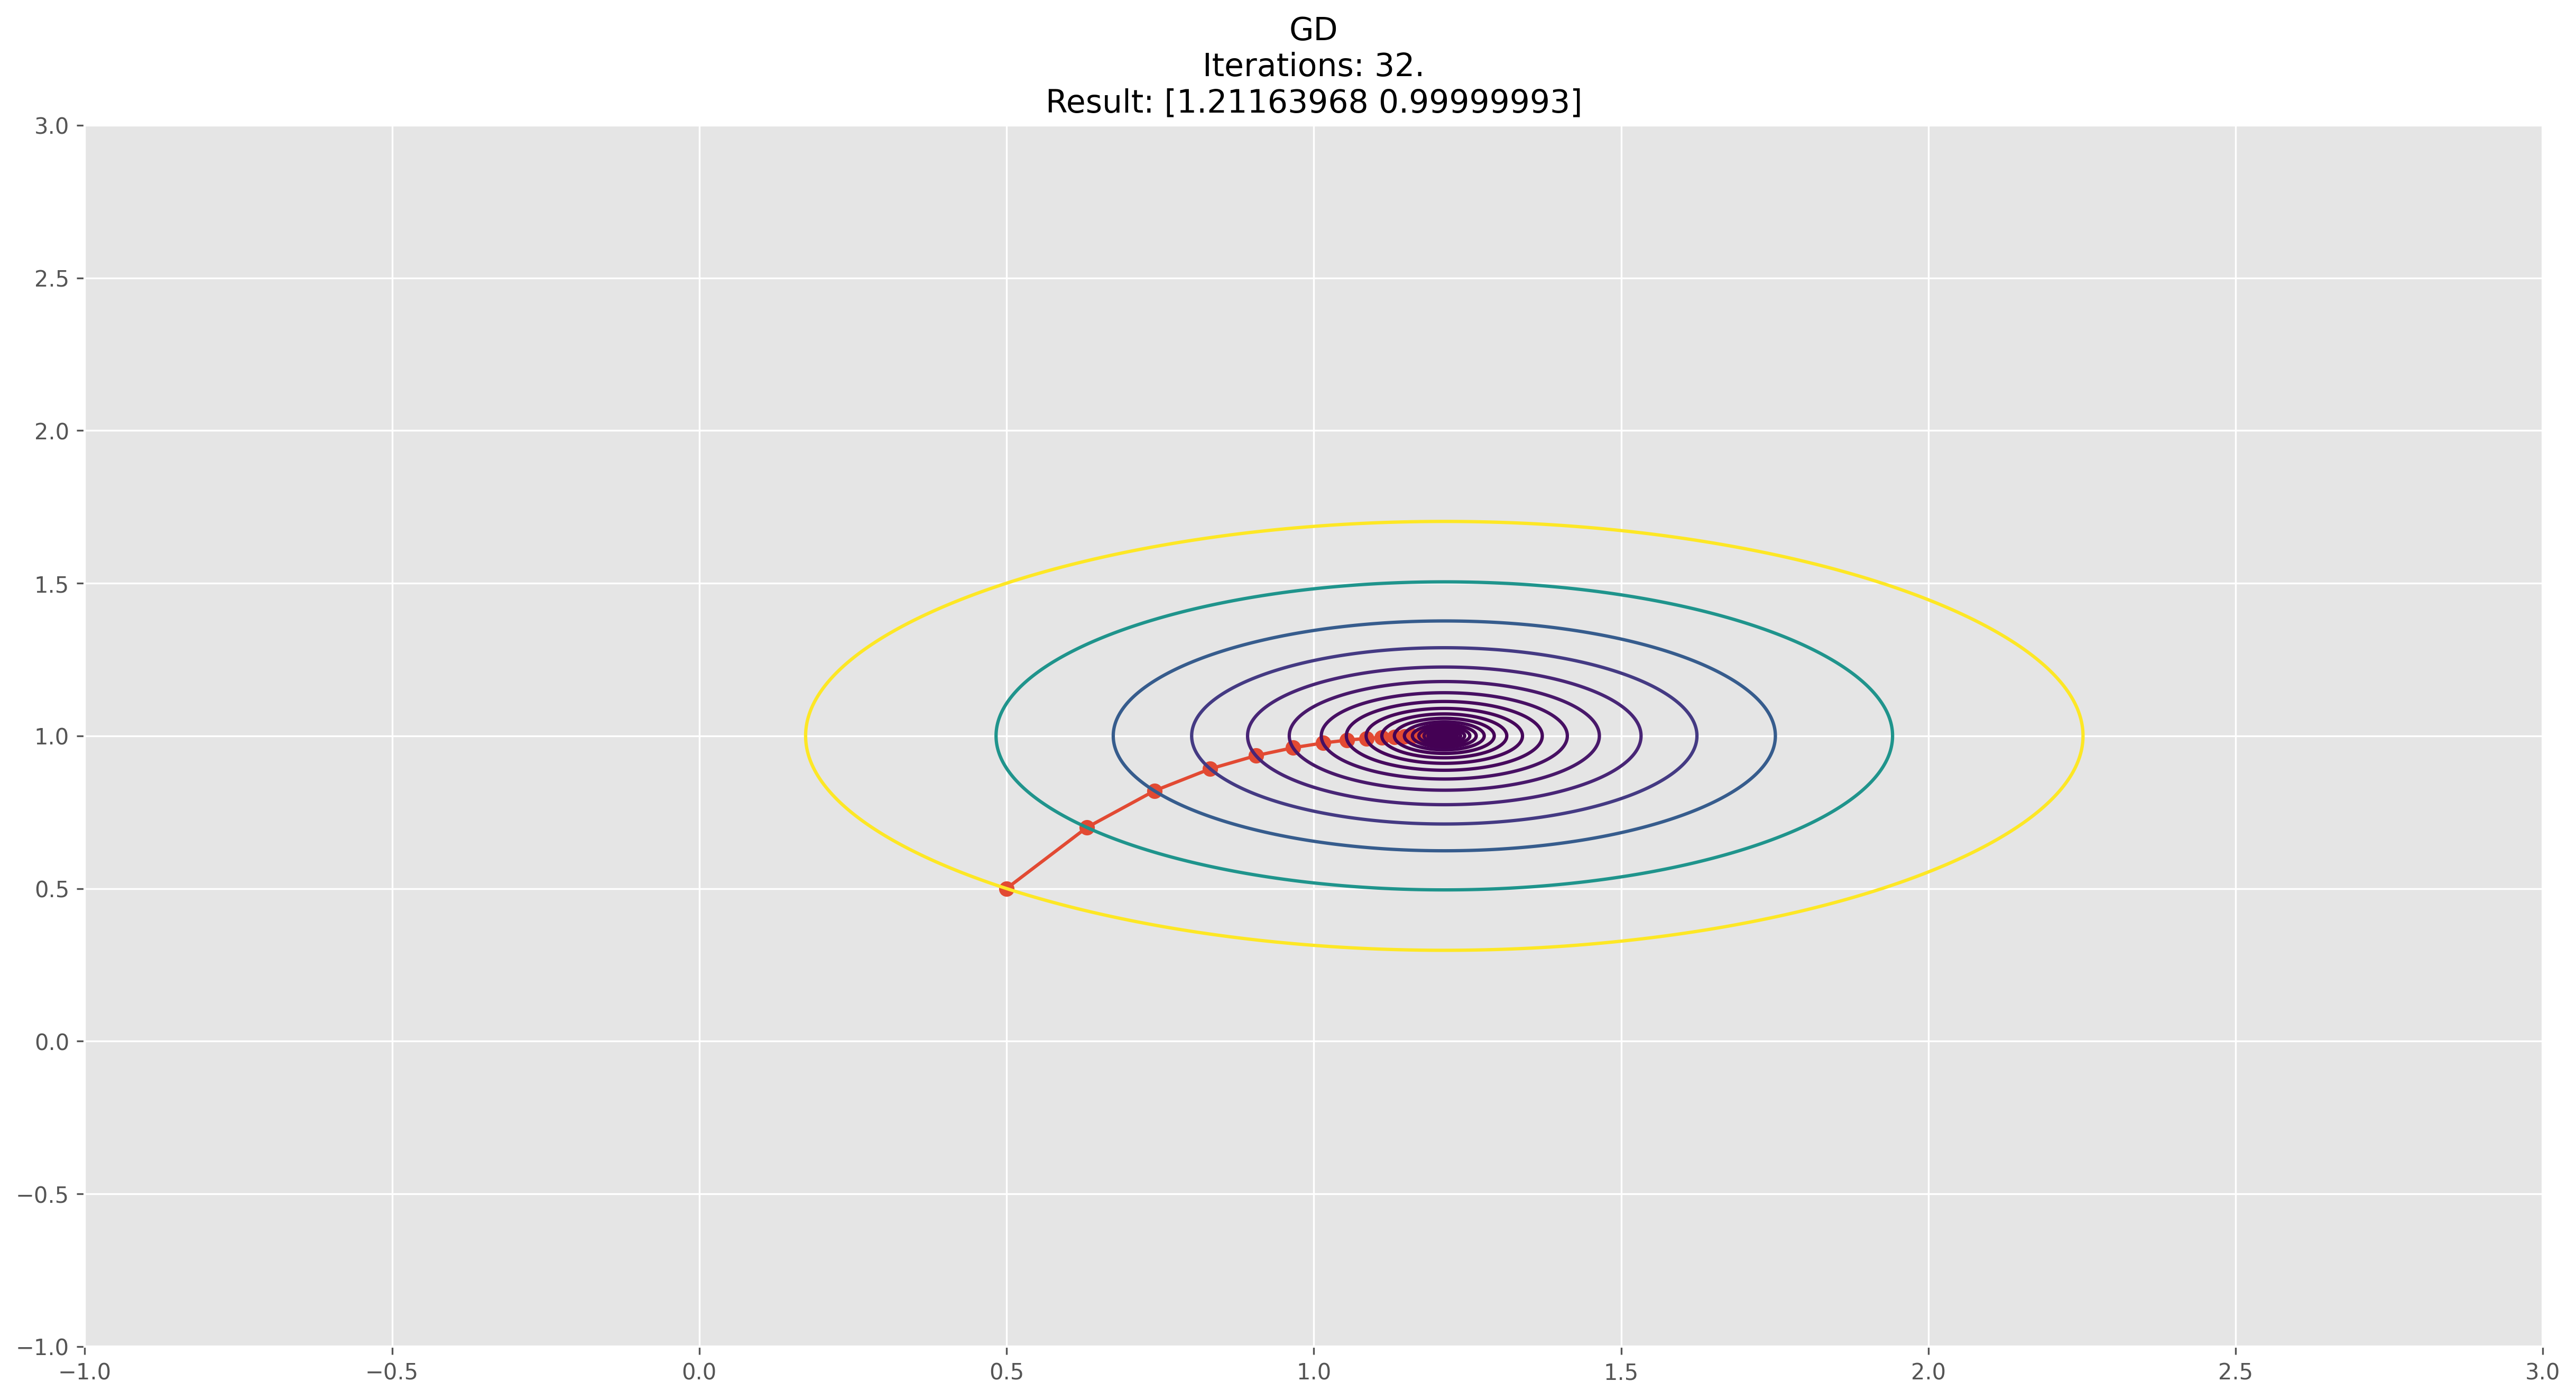

In [103]:
res_gd = gd(fun, start_point, lr=0.2, max_epoch=epoch)
draw_level_lines(fun, plt, res_gd, "GD")

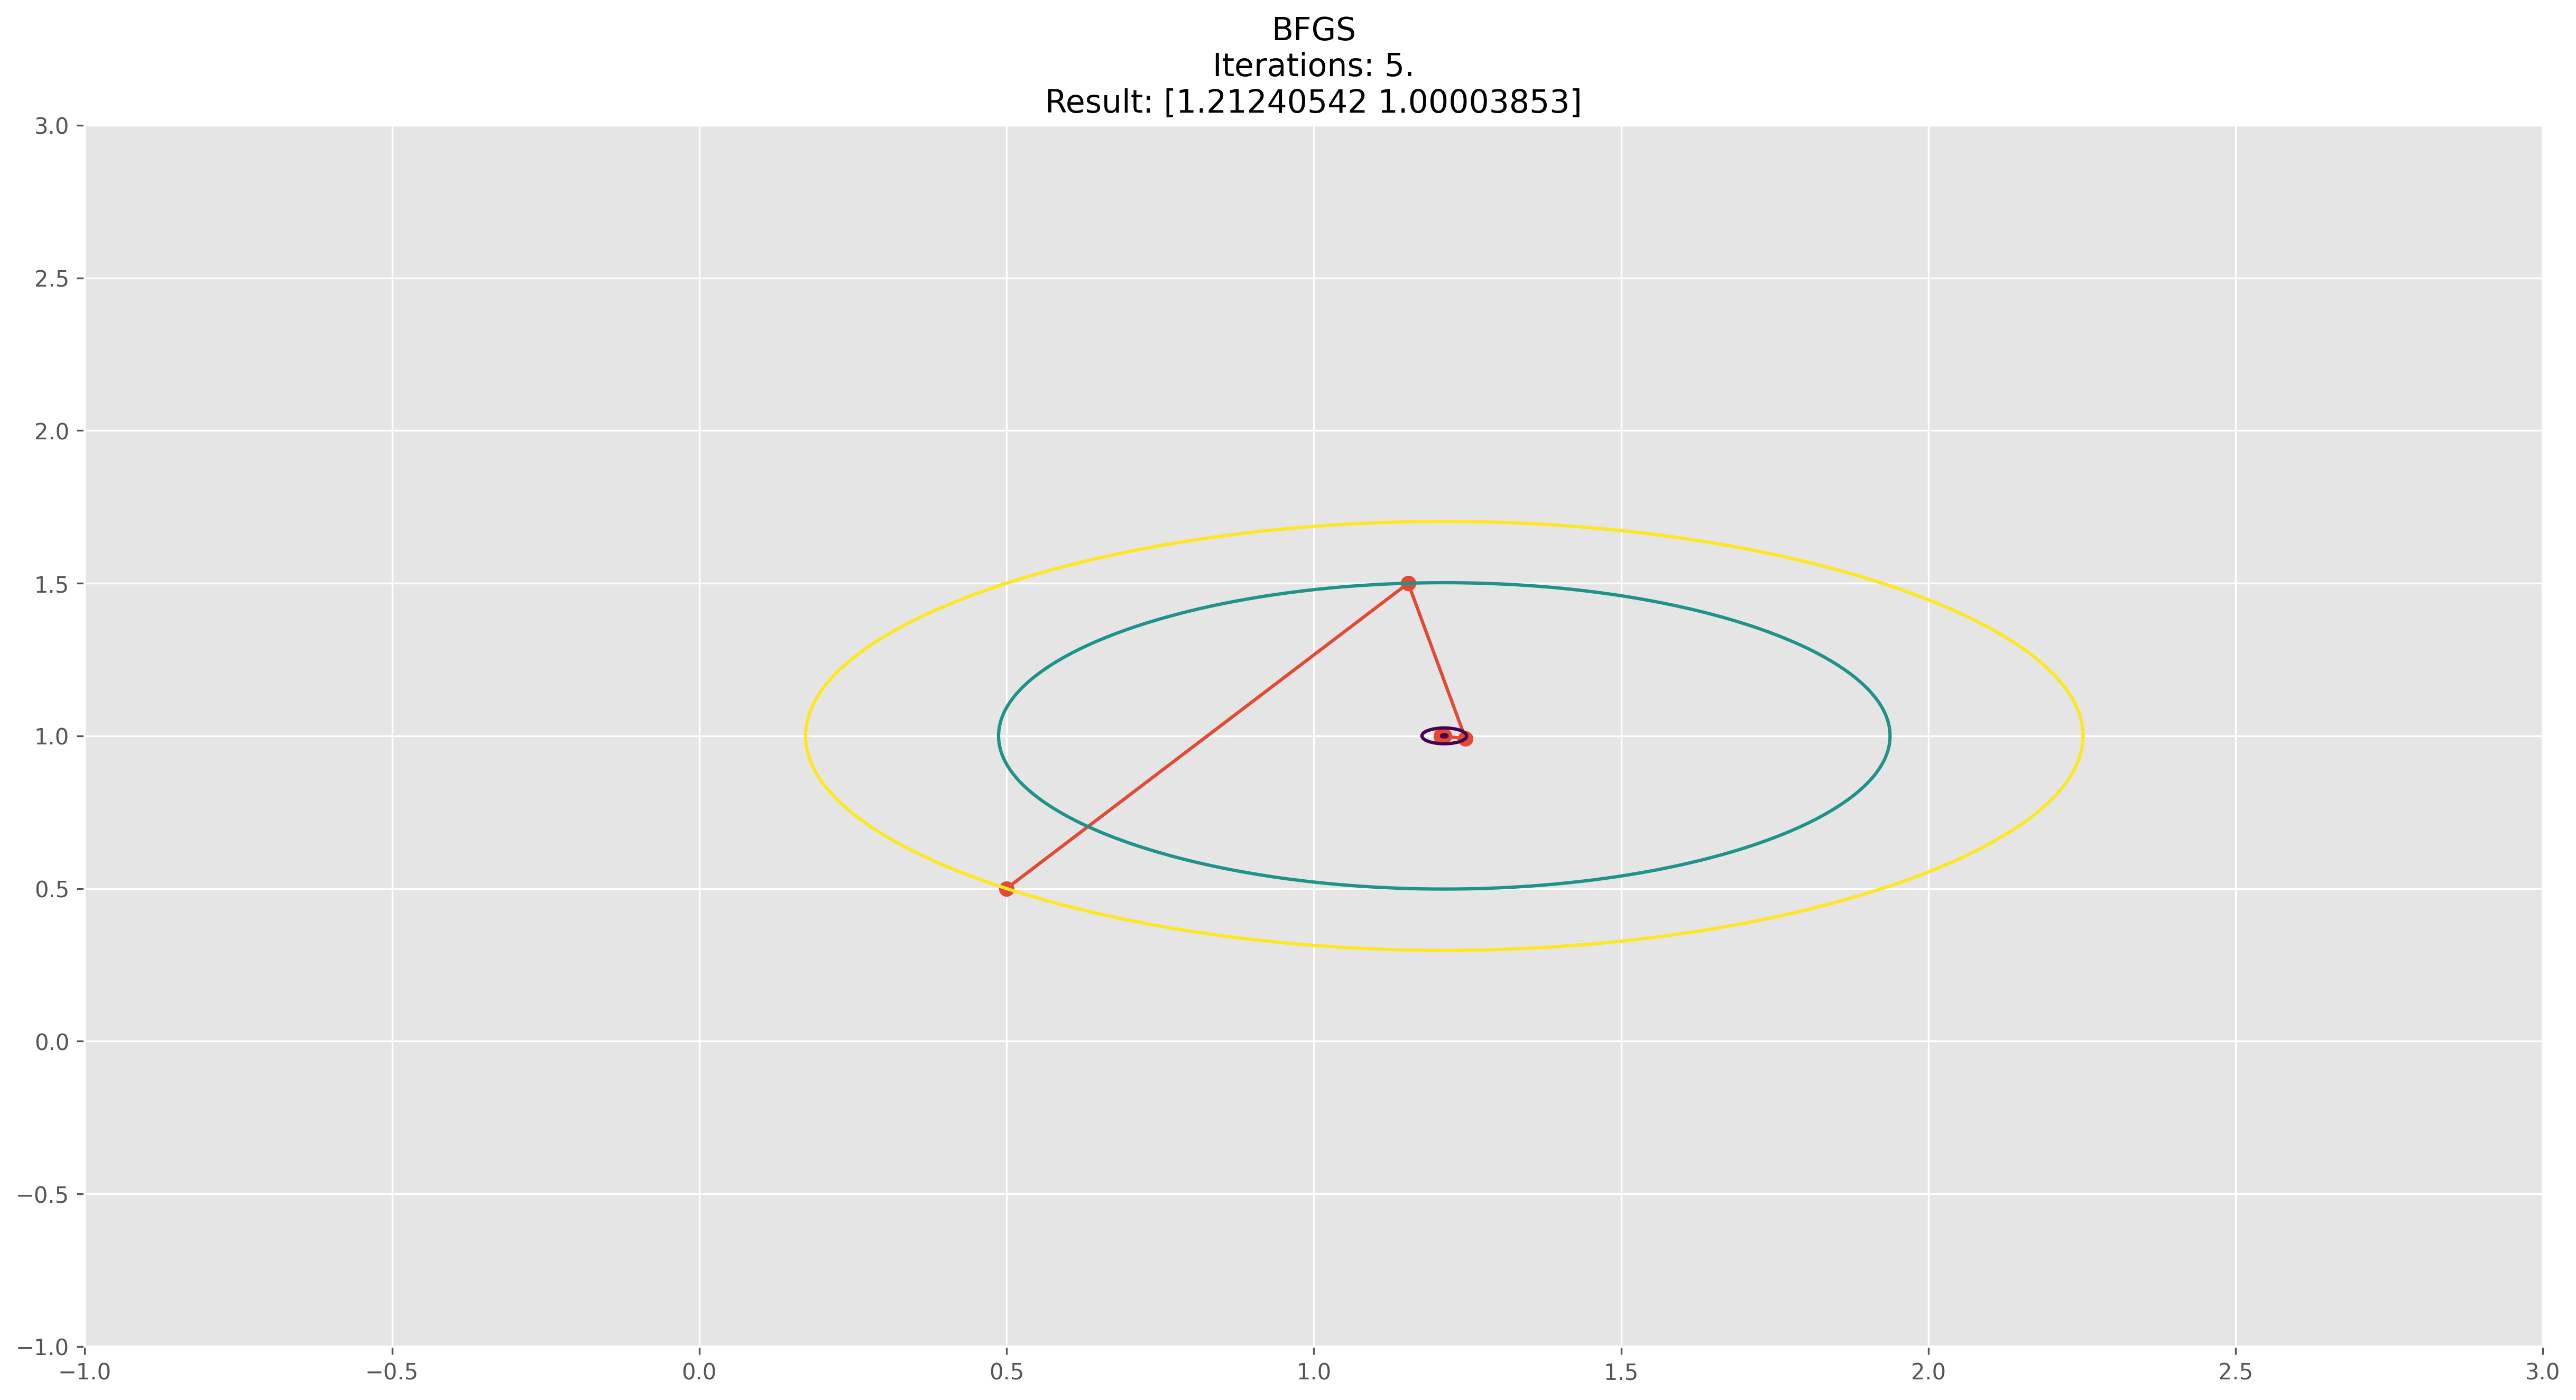

In [104]:
res_bfgs = bfgs(fun, start_point, epoch)
draw_level_lines(fun, plt, res_bfgs, "BFGS")

Как видно, BFGS нашел минимум намного быстрее.

Отодвинем начальную точку дальше

In [105]:
start_point = np.array([-1, -1])

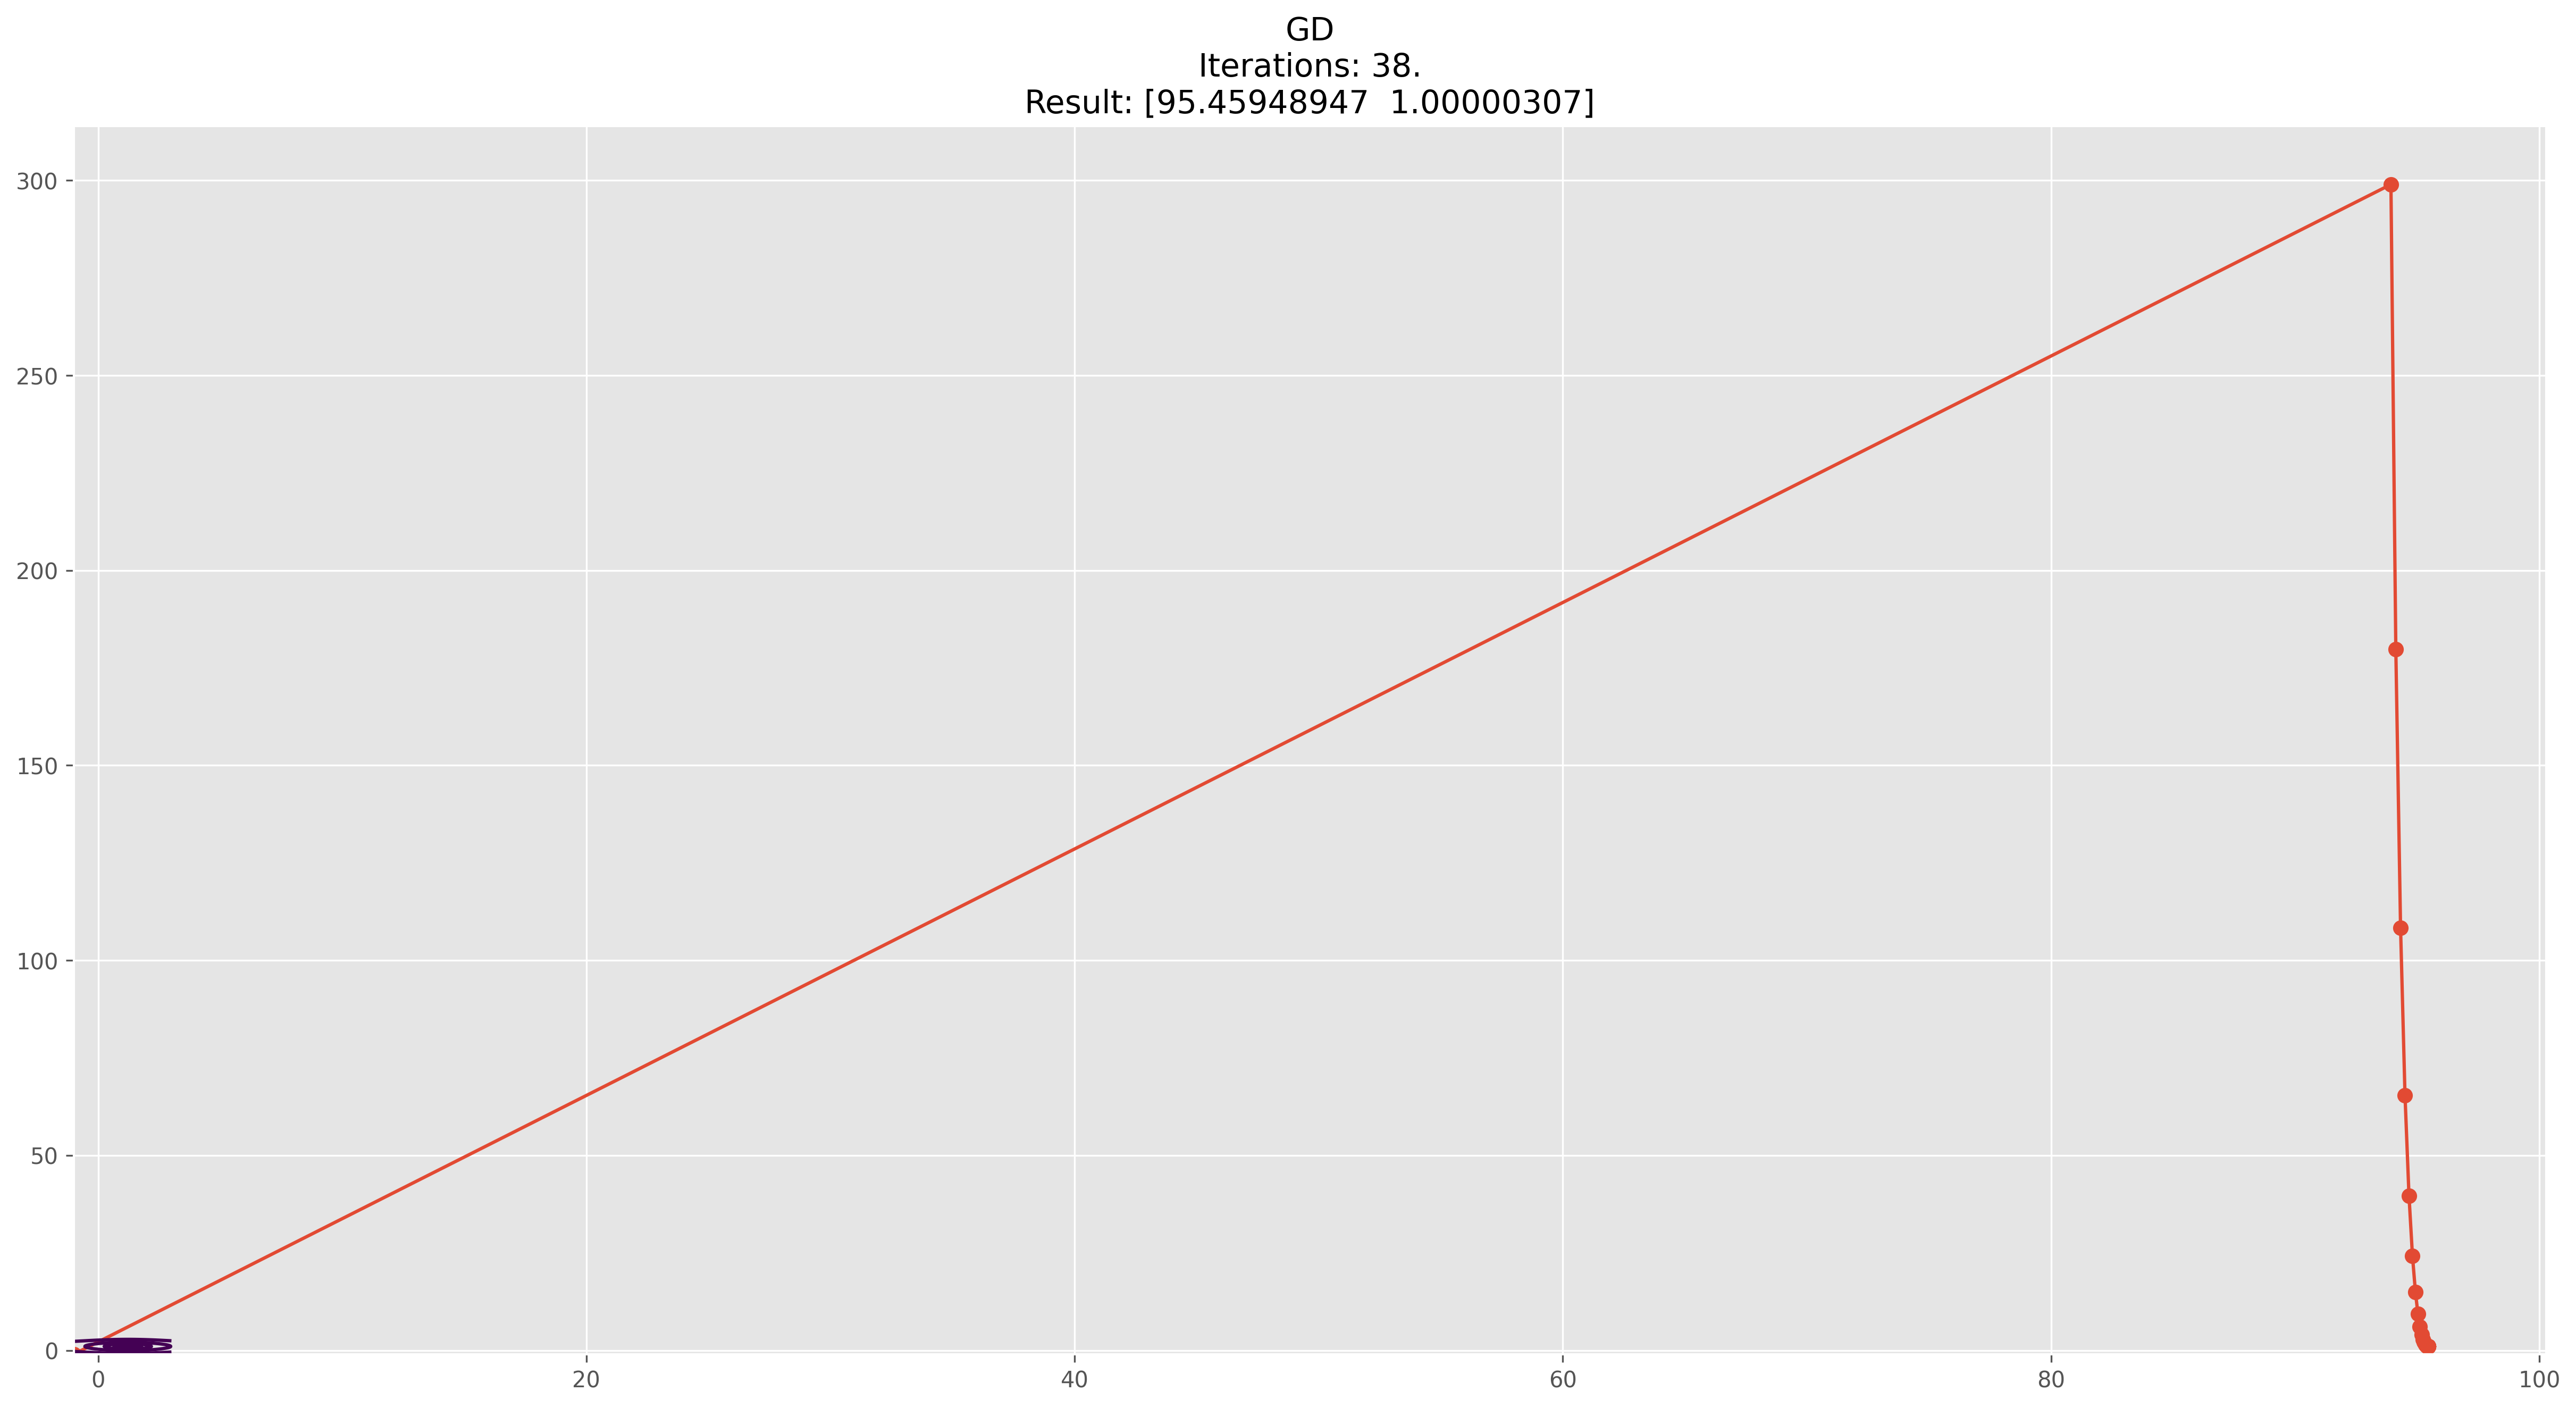

In [114]:
res_gd = gd(fun, start_point, lr=0.2, max_epoch=epoch)
draw_level_lines(fun, plt, res_gd, "GD")

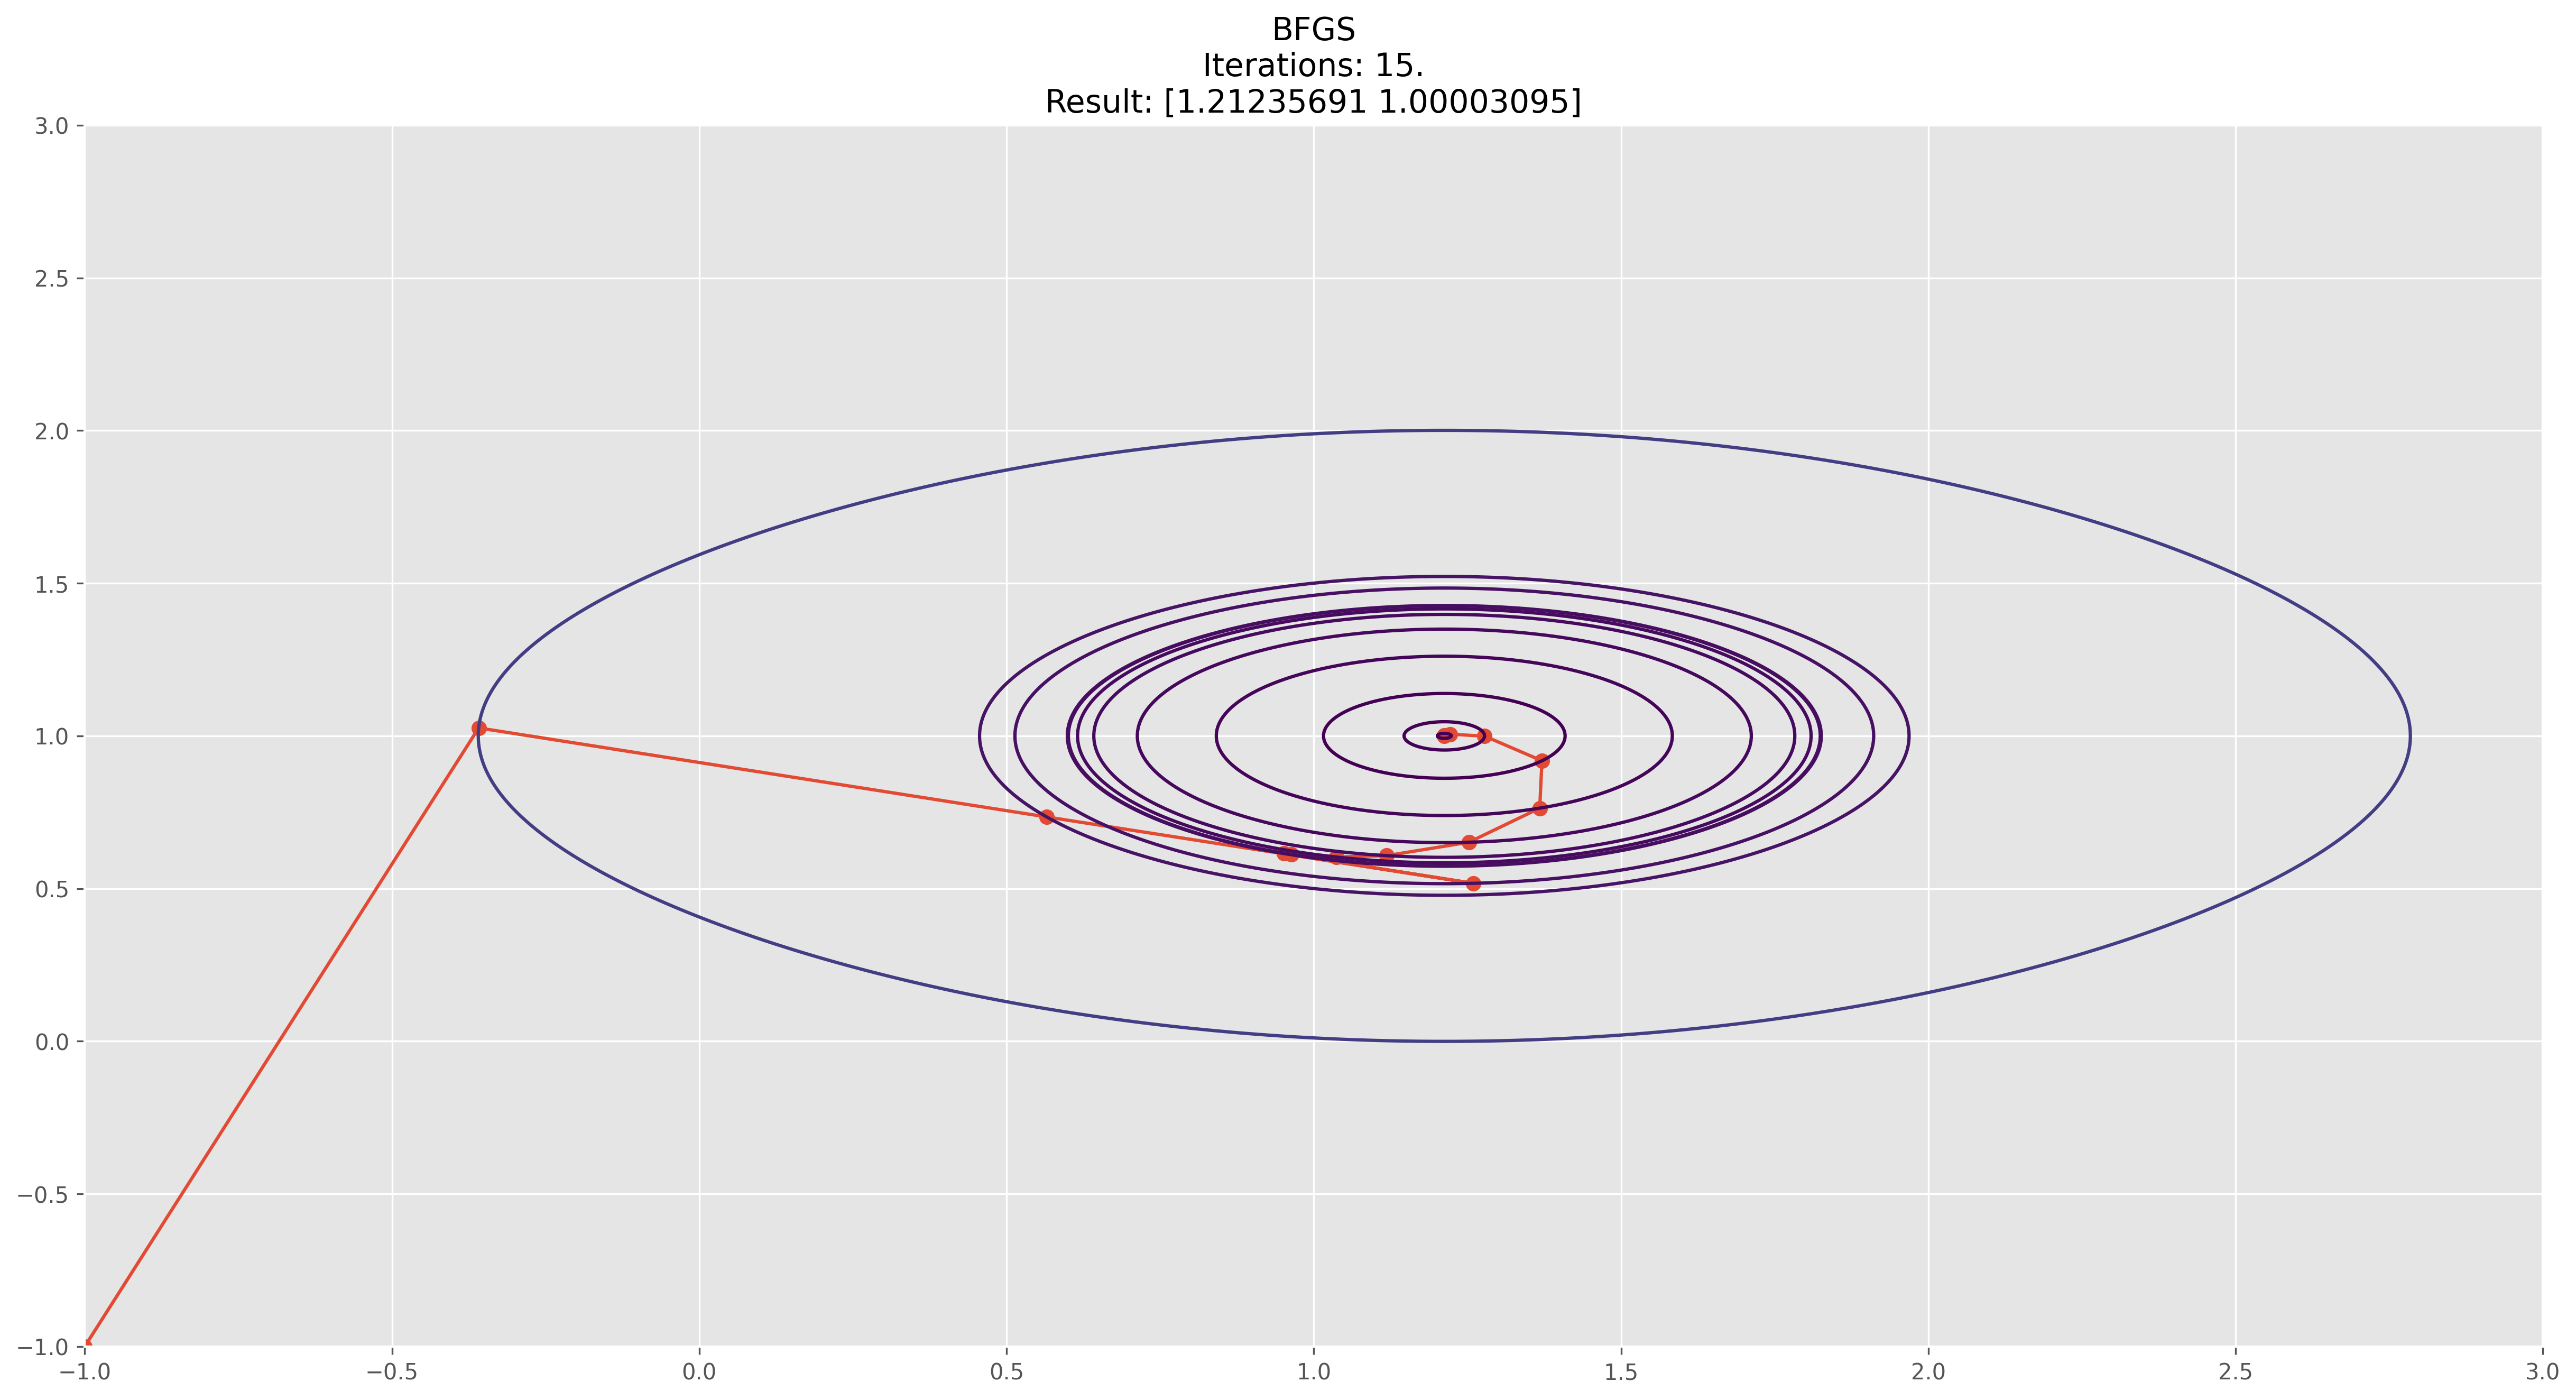

In [107]:
res_bfgs = bfgs(fun, start_point, epoch)
draw_level_lines(fun, plt, res_bfgs, "BFGS")

Градиентный спуск не достиг сходимости (надо подбирать lr). А BFGS успешно сошелся, потратив чуть больше итераций.

## Сравним методы Adam и BFGS

Для исследования возьмем функцию:
$$f(x, y) = (x - 1 + y)^2 + (2.5x - 2.5 + y)^2 + (5.5x - 3 + y)^2 + (3.5x - 2.5 + y)^2$$

In [108]:
def fun2(point):
    return (point[0] - 1 + point[1]) ** 2 + (2.5 * point[0] - 2.5 + point[1]) ** 2 + (5.5 * point[0] - 3 + point[1]) ** 2 + (3.5 * point[0] - 2.5 + point[1]) ** 2

In [109]:
start_point = np.array([-0.5, -0.5])
epoch = 1000

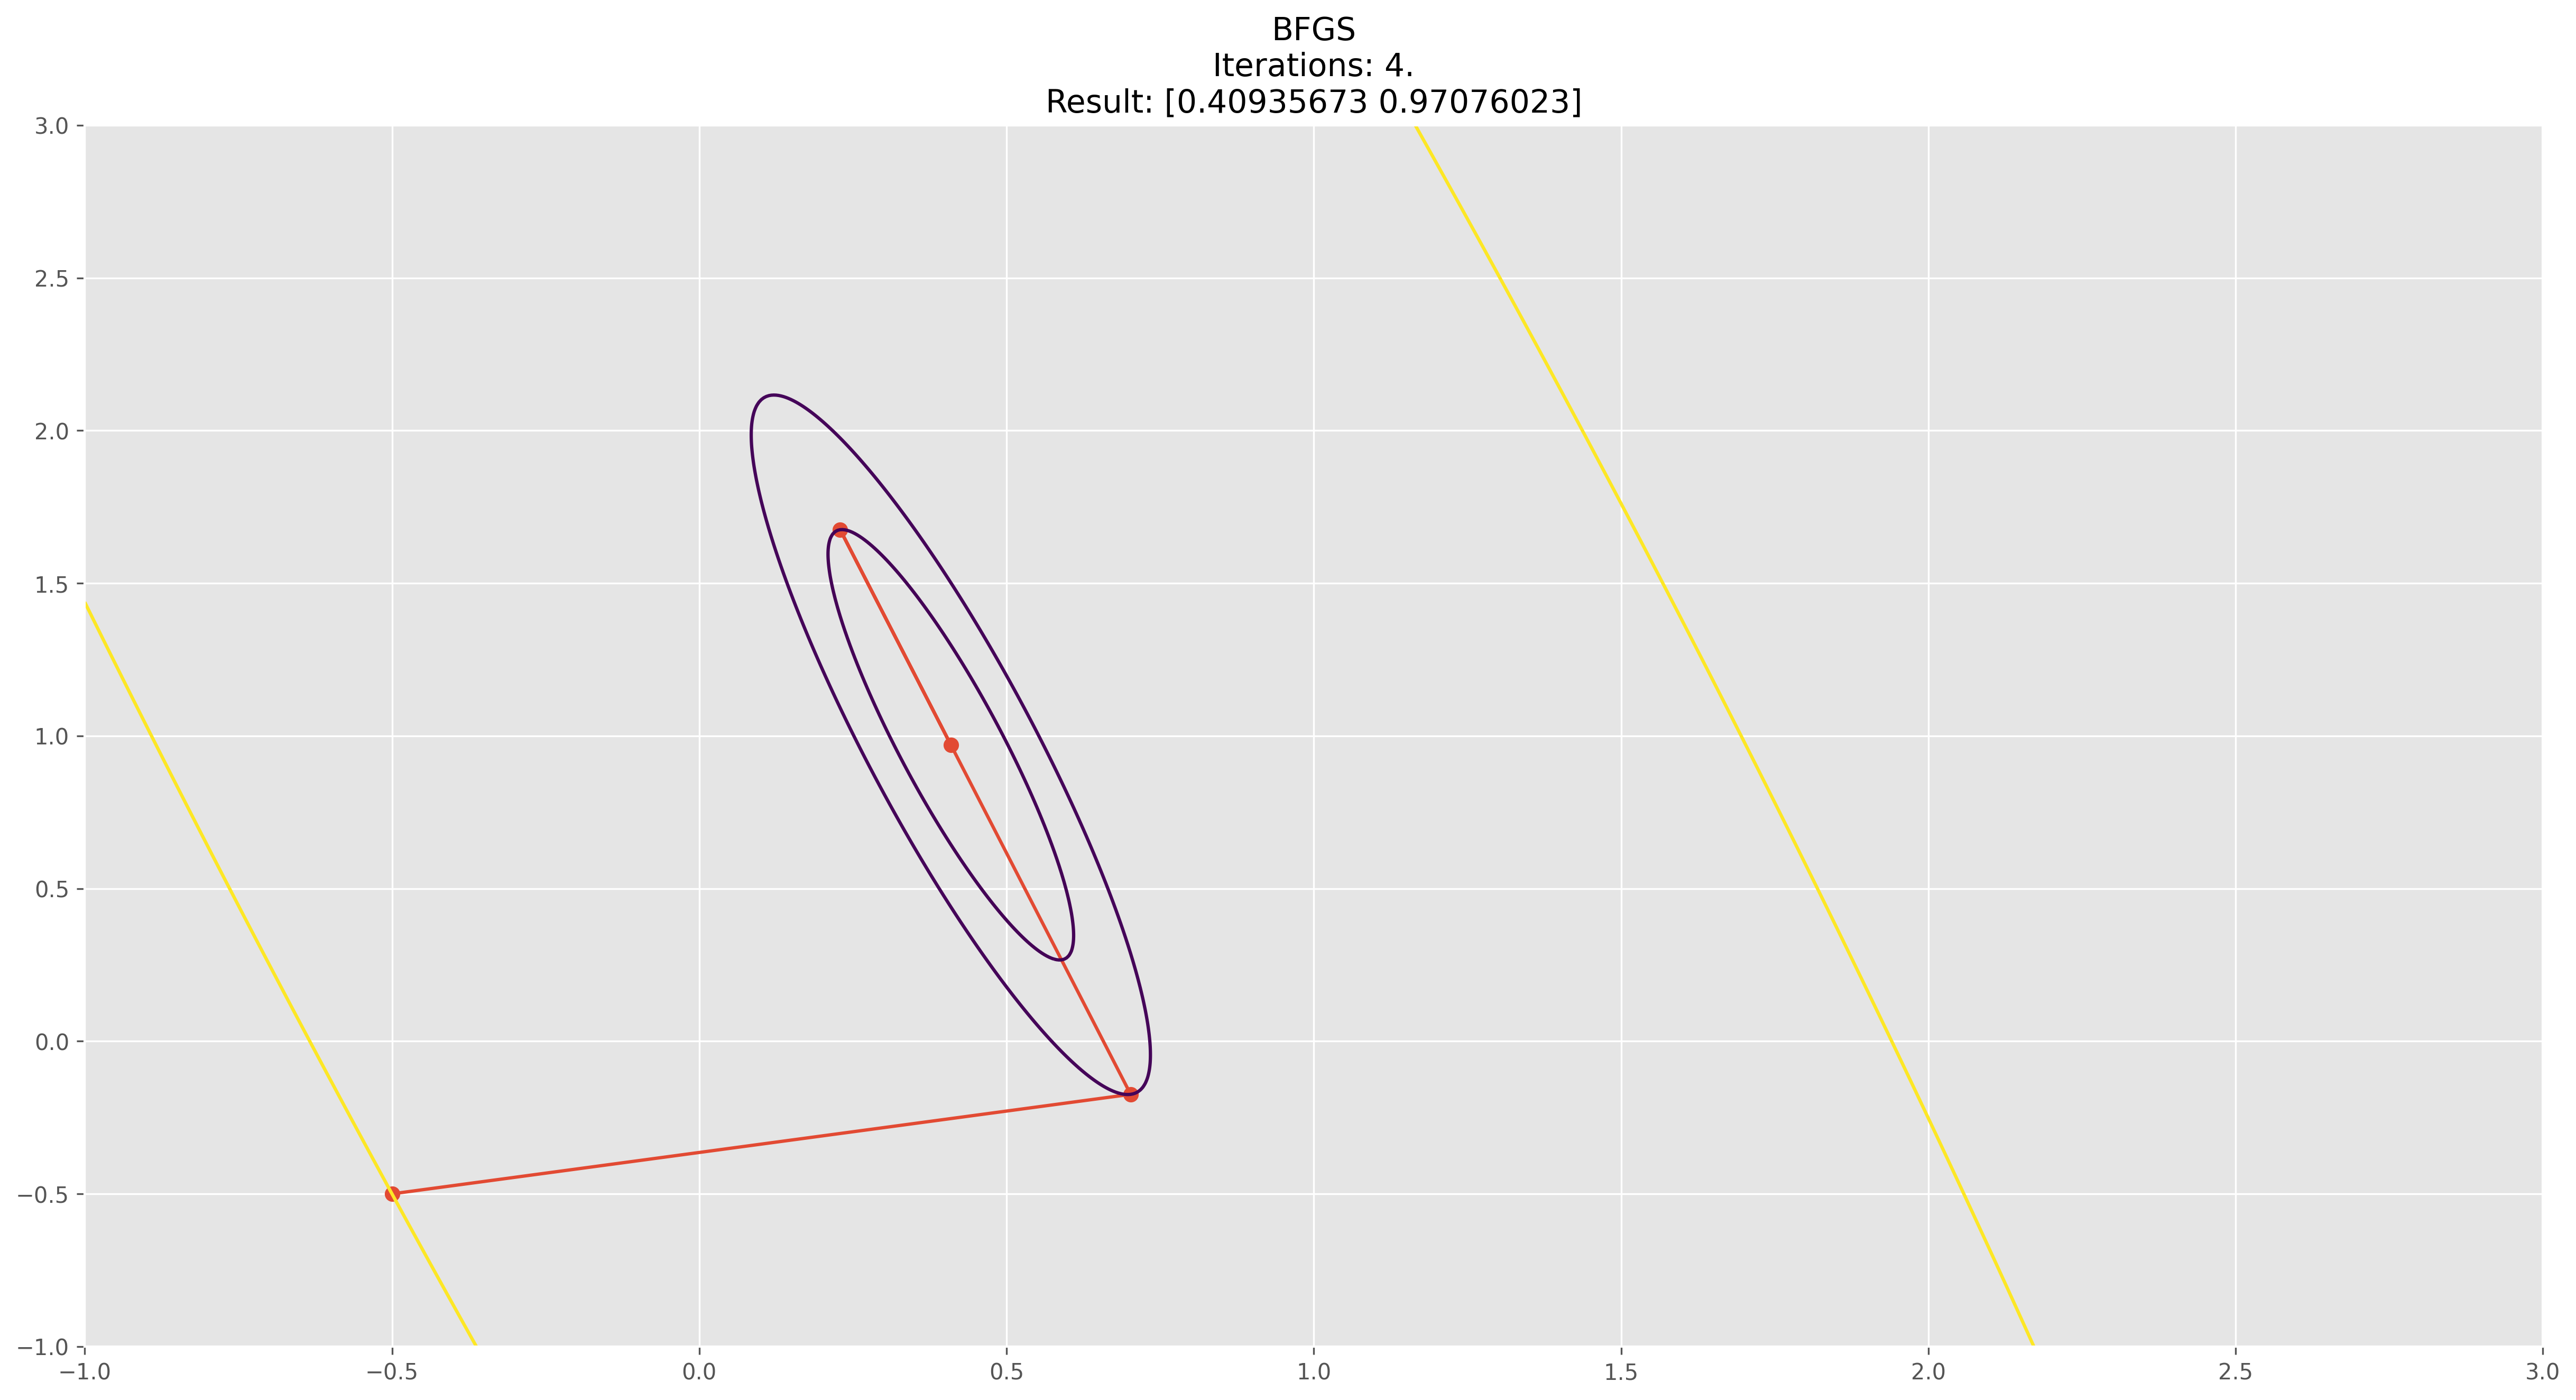

In [110]:
res_bfgs = bfgs(fun2, start_point, epoch)
draw_level_lines(fun2, plt, res_bfgs, "BFGS")

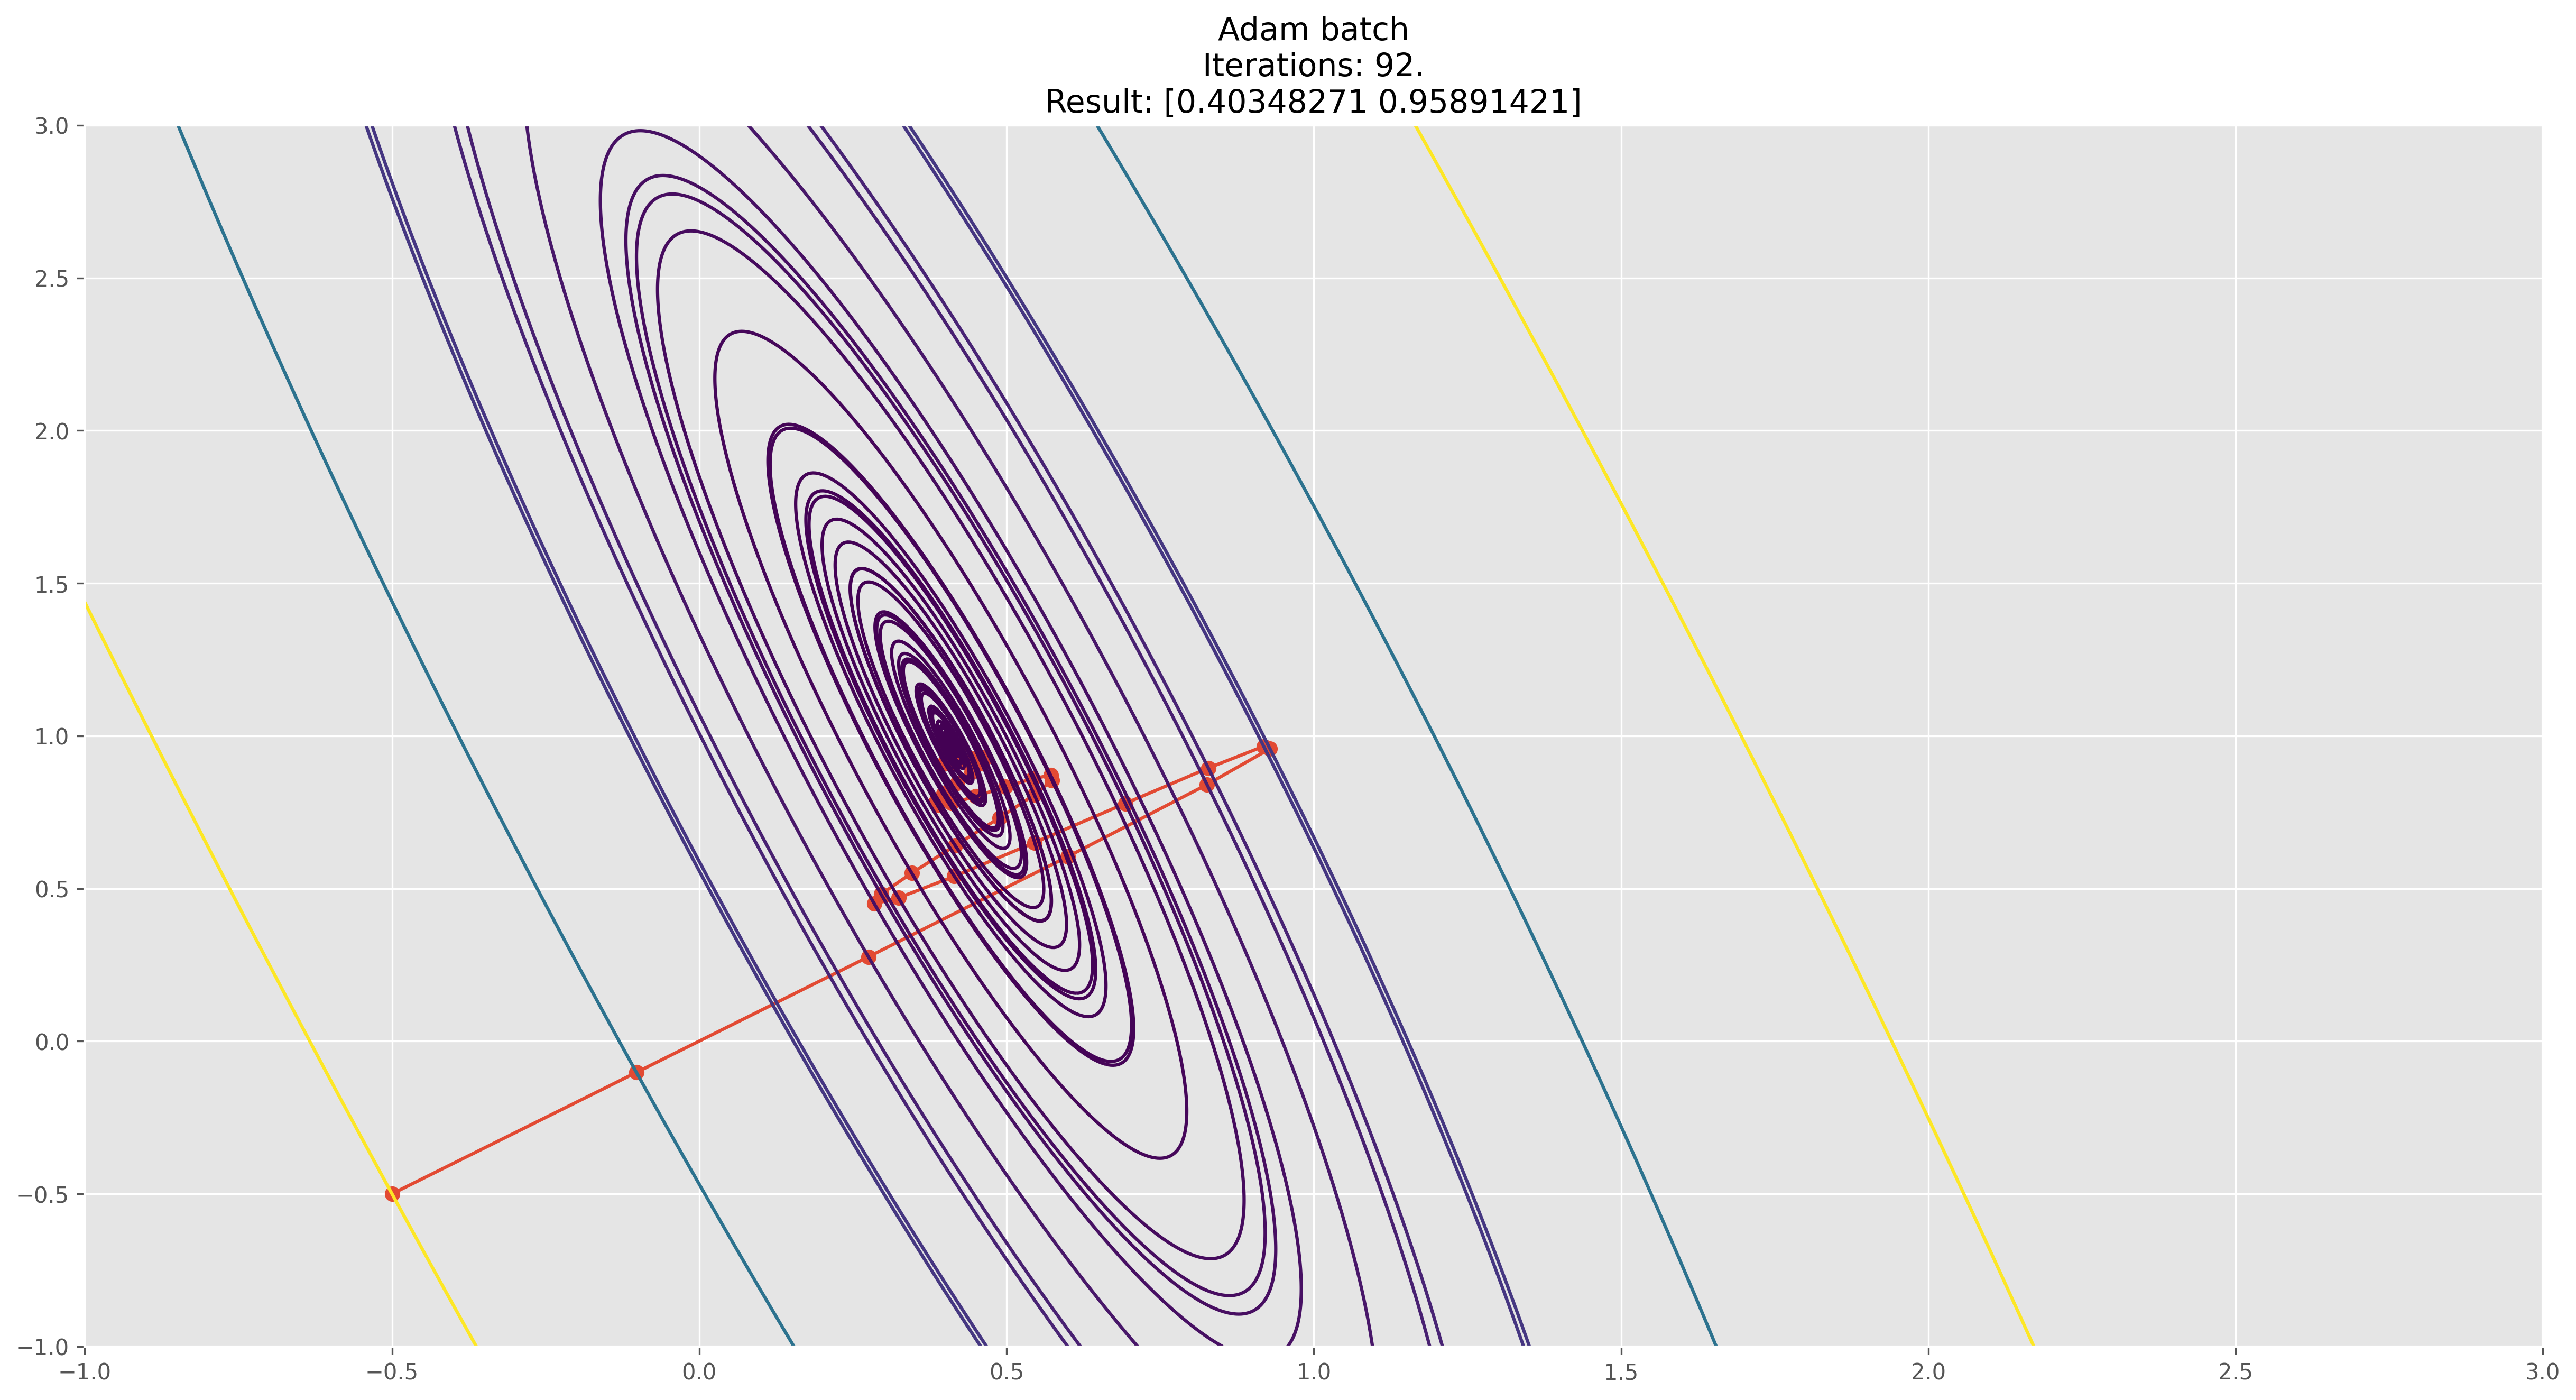

In [111]:
res_adam = adam(fun2, start_point, lr=0.2, max_epoch=epoch)
draw_level_lines(fun2, plt, res_adam, "Adam batch")

Очевидно преимущество BFGS - не нужно подбирать lr и начальную точку вблизи минимума.

## Вывод

Пока размерность небольшая и на каждой итерации не используется много памяти, BFGS является очень эффективным методом для поиска минимума функции.

## L-BFGS

Так как хранить матрицу $H$ размера $n * n$ затратно, можно хранить несколько векторов, которые неявно представляют аппроксимацию обратного гессиана.

L-BFGS сохраняет историю последних m обновлений положения $x$ и градиента $\nabla f(x)$, где обычно размер истории m может быть небольшим.

Будем хранить m таких обновлений:
$$s_k=x_{k+1}-x_k$$
$$y_k=g_{k+1}-g_k$$

На $k$-й итерации текущий градиент $q_k = g_k$.

Для $i = k - 1, ..., k - m$ рекурсивно вычисляем $\alpha_i = \rho_i {s_i}^T q$ и $q_i = q_{i + 1} - \alpha_i y_i$

После $z_i = H_i q_i$

Для $i = k - m, ..., k - 1$ - $\beta_i = \rho_i {y_i}^T z_i$ и $z_{i+1} = z_i + s_i(\alpha_i - \beta_i)$

Находим точку, в направлении которой будем производить поиск: $p_k = - z_k$



In [112]:
def lbfgs(f, start, max_epoch, m=10, delta=DELTA):
    grad_f = gradient(f)

    points = np.zeros((max_epoch, len(start)))
    points[0] = start

    s = deque(maxlen=m)
    y = deque(maxlen=m)
    rho = deque(maxlen=m)

    H = 1
    point = start.copy()
    i = 1
    while i < max_epoch:
        a = np.zeros(m)
        q = grad_f(point)

        if i > m:
            for j in reversed(range(len(s))):
                a[j] = rho[j] * np.dot(s[j], q)
                q = q - a[j] * y[j]

        z = H * q

        if i > m:
            for j in range(len(s)):
                b = rho[j] * np.dot(y[j], z)
                z = z + s[j] * (a[j] - b)

        p = -z
        alpha = opt.line_search(f, grad_f, point, p, amax=100)[0]
        if alpha is None:
            alpha = DELTA

        points[i] = point + alpha * p
        s.append(points[i] - point)
        point = points[i]

        gr_new = grad_f(point)
        y.append(gr_new - q)

        i += 1
        if stop(gr_new, delta):
            break

        rho.append(1.0 / (np.dot(y[-1], s[-1]) + 1e-8))
        H = np.dot(s[-1], y[-1]) / np.dot(y[-1], y[-1])

    return points[:i]



Для тестирования возьмем m = 5, так как число итераций мало.

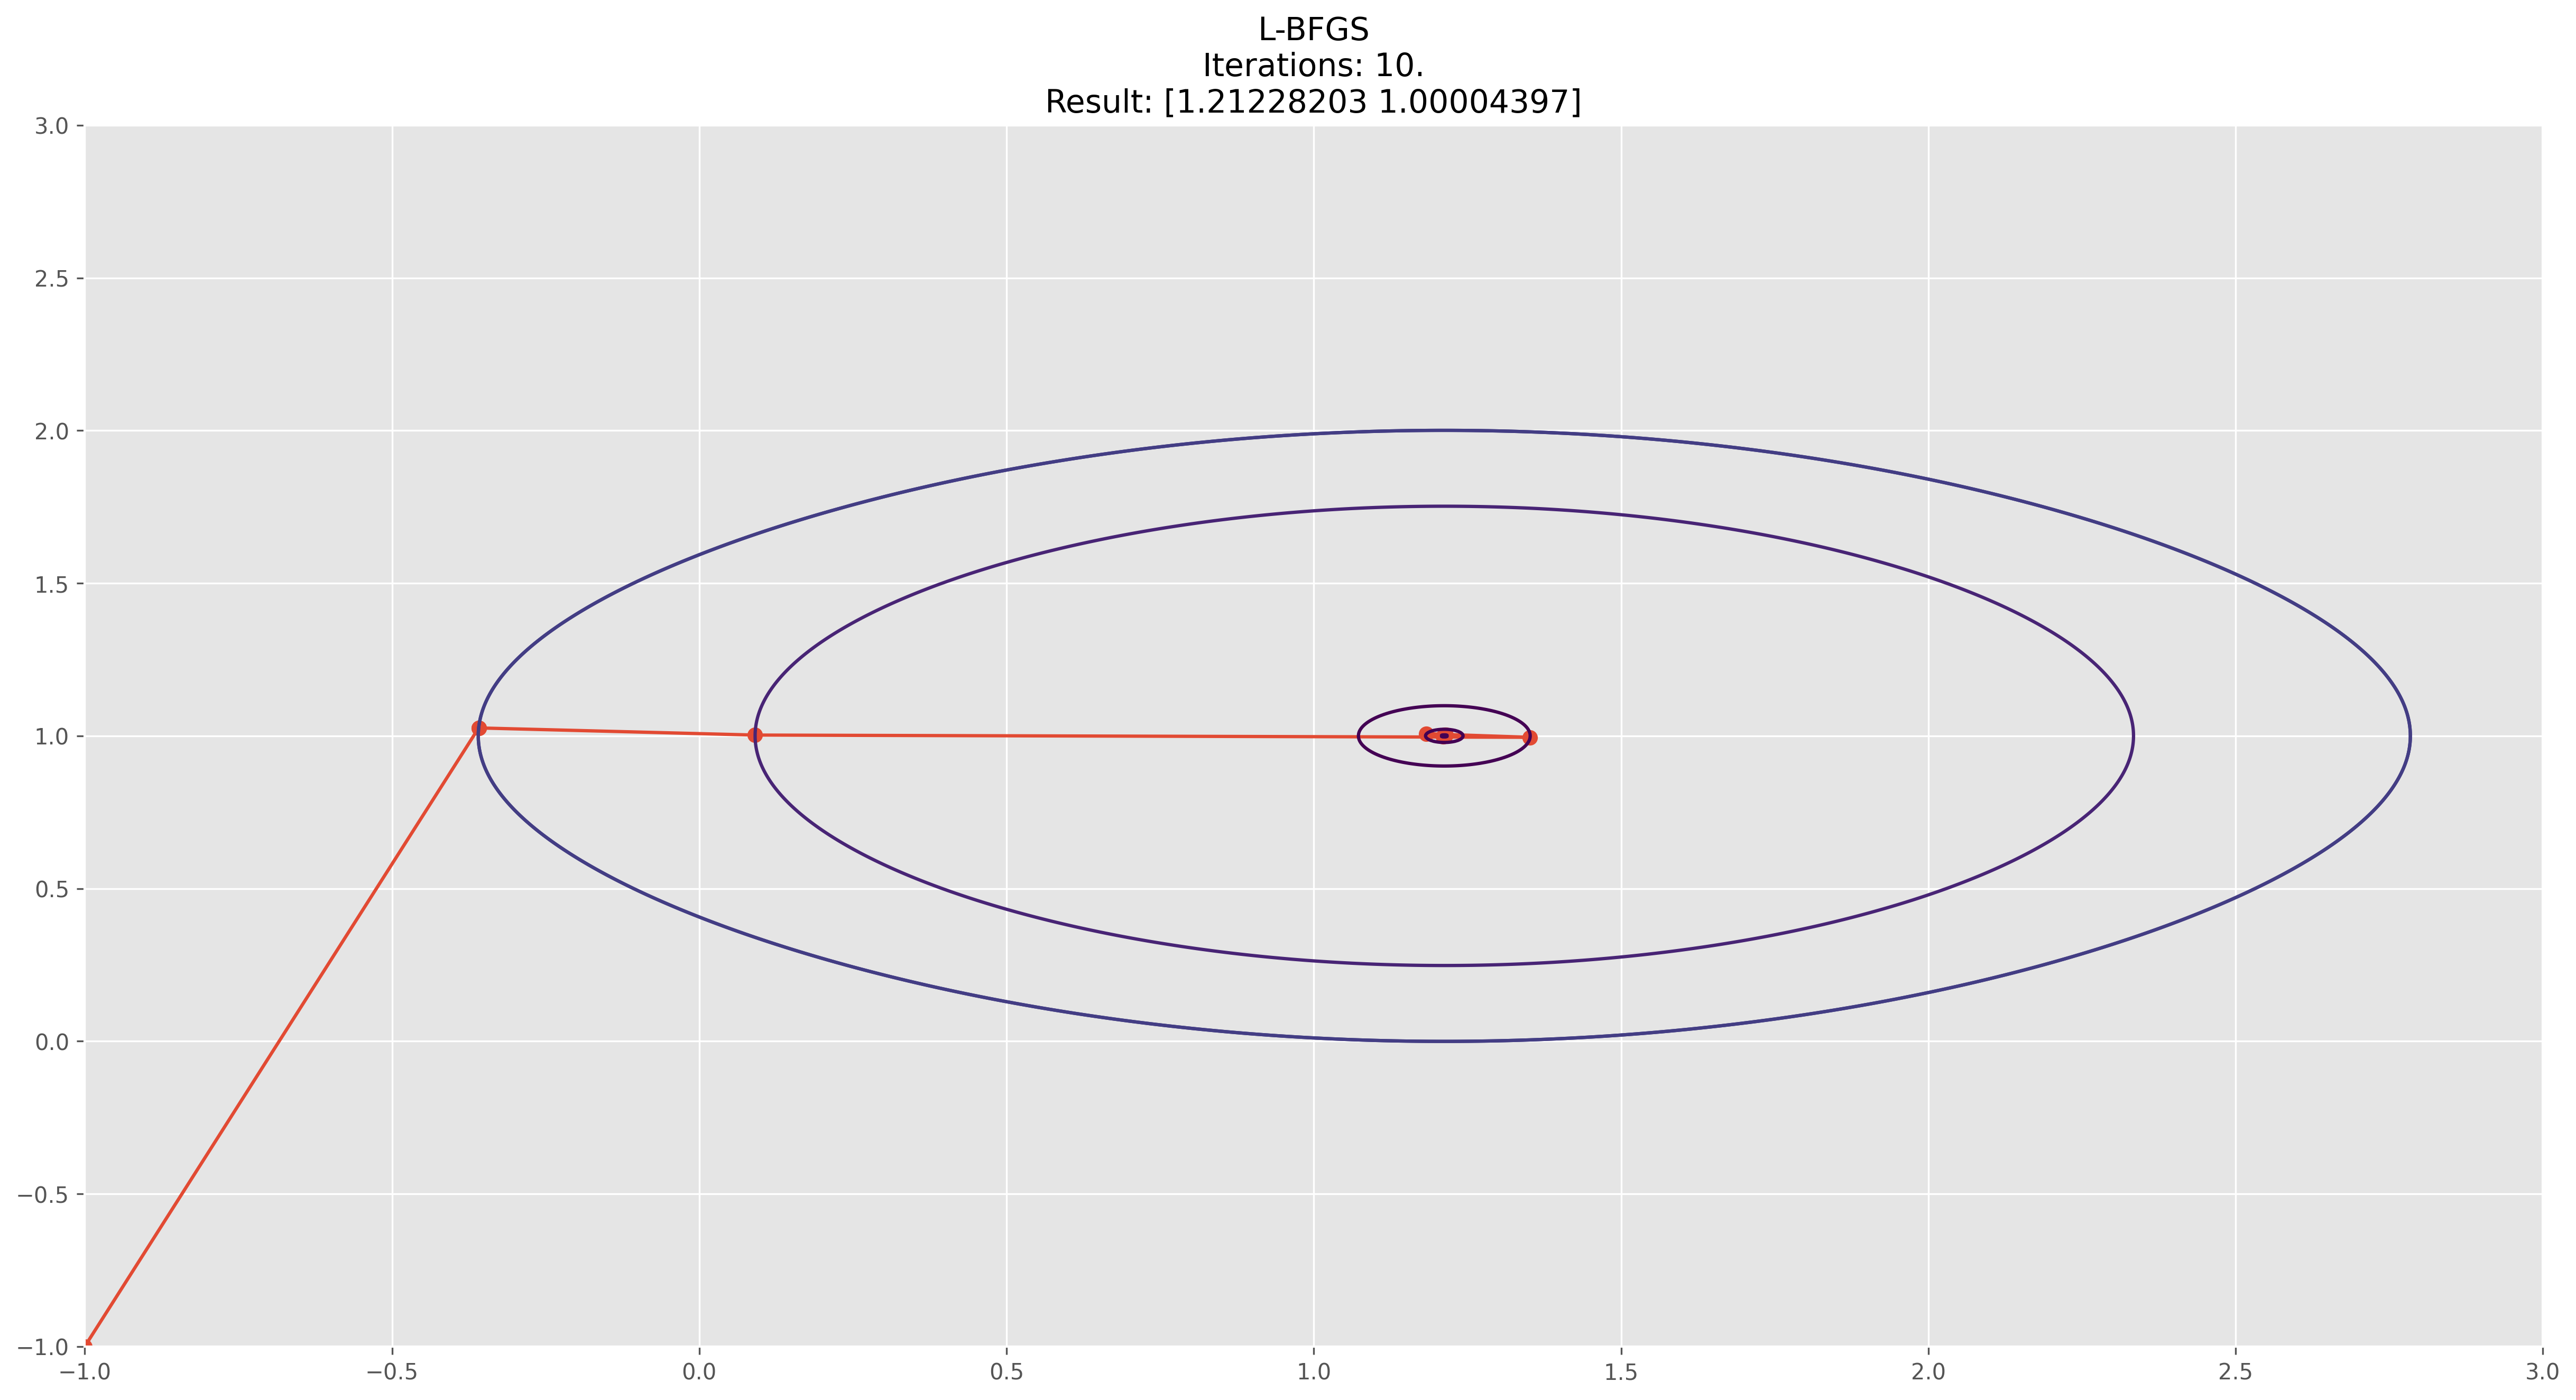

In [117]:
start_point = np.array([-1, -1])
res_lbfgs = lbfgs(fun, start_point, max_epoch=100, m=5)
draw_level_lines(fun, plt, res_lbfgs, "L-BFGS")